In [1]:
from ay_torch import *
import os

In [2]:
from cnn_sqptn1r_1 import SqPtn1rDataset
root='data_generated/sqptn1r/'

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [3]:
dset_train= SqPtn1rDataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1rDataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [4]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][2])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][2])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_train[0] label value: tensor([0.3626])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_test[0] label value: tensor([0.7494])
dset_test[0][0] value range: tensor(0.) tensor(1.)


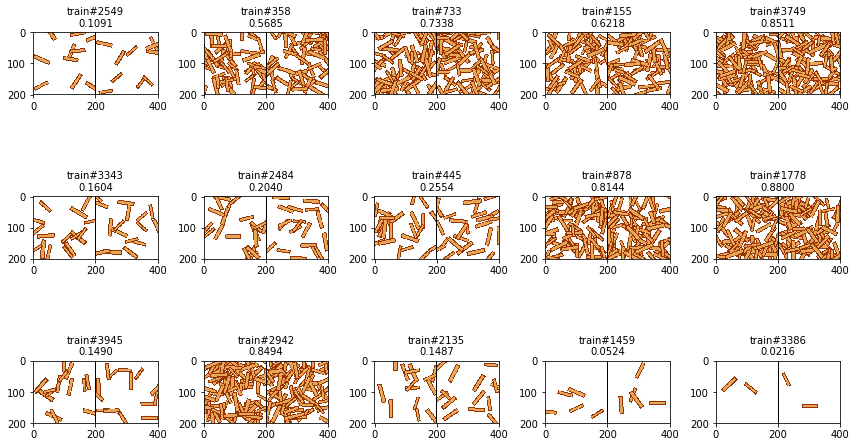

In [5]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [HStackImages(d[i][0],d[i][1]) for i in idxes]
labels= [f'train#{i}\n{d[i][2].item():.4f}' for i in idxes]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock

In [9]:
class TResDenseNet(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, resnet_args=None,
               n_hiddens=2, hidden_channels=256, p_dropout=0.0):
    super(TResDenseNet,self).__init__()
    default_resnet_args= dict(expansion=1, layers=[2, 2, 2, 2])
    resnet_args= MergeDict(default_resnet_args,resnet_args) if resnet_args else default_resnet_args
    self.resnet= TResNet(TResBlock, **resnet_args, in_channels=in_imgshape[0], with_fc=False)
    ndim_resnet= torch.flatten(self.resnet(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_resnet*2, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens-1)],
            torch.nn.Dropout(p_dropout) if n_hiddens-1>0 else TNoop(),
            torch.nn.Linear(hidden_channels, out_channels),
            )
    else:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(ndim_resnet*2, out_channels),
            )
  def forward(self, x1, x2):
    x= torch.cat((self.resnet(x1),self.resnet(x2)),1)
    return self.fc(x)

In [10]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNet(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),y
logger= TLogger()
disp= TDisp()

In [11]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNet                                       --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


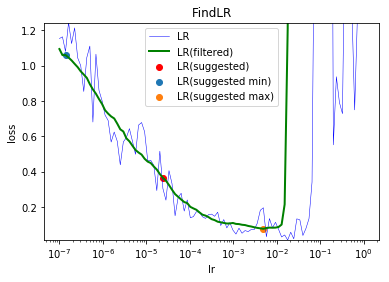

lr= 2.3988329190194914e-05, lr_min=1.3803842646028847e-07, lr_max=0.0048977881936844644


In [12]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
75	0.00023211	0.00068532	0.02587807	12.692064
76	0.00051441	0.00057594	0.02382704	12.800595
77	0.00053352	0.00062125	0.02479549	12.764260
78	0.00030702	0.00052498	0.02270901	12.654475
79	0.00019105	0.00046681	0.02136519	12.748285
i_epoch	loss(train)	loss(test)	metric(test)	time
80	0.00023634	0.00044676	0.02093299	12.763747
81	0.00060516	0.00068909	0.02610315	12.875621
82	0.00040236	0.00060422	0.02435285	12.791015
83	0.00022417	0.00050155	0.02216420	12.805248
84	0.00018965	0.00049553	0.02201398	12.802444
i_epoch	loss(train)	loss(test)	metric(test)	time
85	0.00023913	0.00065223	0.02537078	12.766841
86	0.00043110	0.00045715	0.02114777	12.773011
87	0.00042896	0.00053251	0.02280404	12.774483
88	0.00032937	0.00052963	0.02281857	12.783426
89	0.00018845	0.00045240	0.02101438	12.696433
i_epoch	loss(train)	loss(test)	metric(test)	time
90	0.00027141	0.00145968	0.03804333	12.750224
91	0.00062574	0.00056320	0.02344181	12.666065
92	0.00036522	0.000463

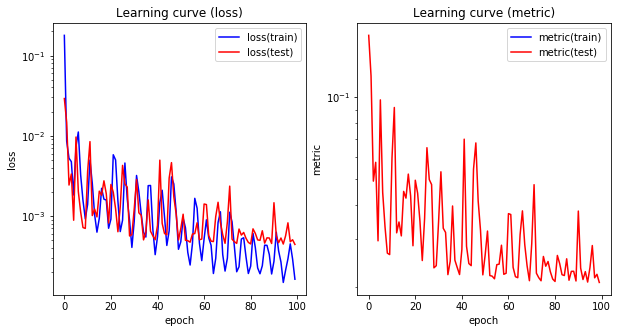

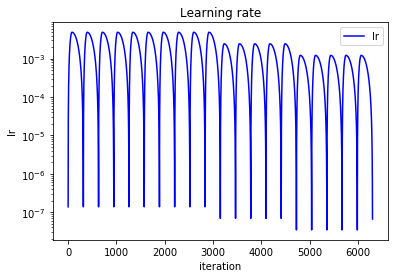

In [17]:
lr_min/=2;lr_max/=2
for i in range(5):
  FitOneCycle(net, n_epoch=5, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Plot()
logger.PlotLR()

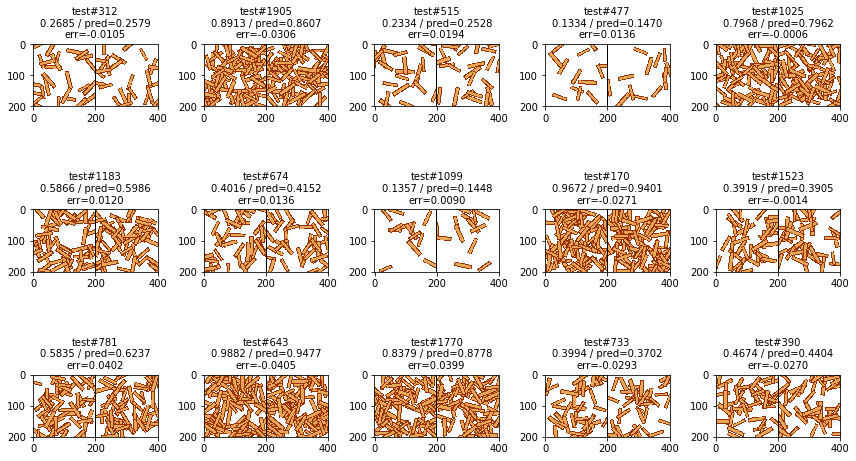

In [18]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= Eval(net,(imgs,imgsr),device=device).cpu()
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

# ResNet + ResDenseBlock + ResNetDecoder (Auto Encoder)

In [80]:
class TResDenseNetWithAE(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, layers=[2, 2, 2, 2], 
               encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=None, n_hiddens2=1, hidden_channels2=None, p_dropout=0.0):
    super(TResDenseNetWithAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_encoder, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
            torch.nn.Dropout(p_dropout) if n_hiddens>0 else TNoop(),
            # torch.nn.Linear(hidden_channels, latent_dim),
            TResDenseBlock(hidden_channels, latent_dim),
            )
    else:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            # torch.nn.Linear(ndim_encoder, latent_dim),
            TResDenseBlock(ndim_encoder, latent_dim),
            )
    if hidden_channels2 is not None:
      self.fc_out= torch.nn.Sequential(
            TResDenseBlock(latent_dim*2, hidden_channels2),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels2, hidden_channels2) for i in range(n_hiddens2)],
            torch.nn.Dropout(p_dropout) if n_hiddens2>0 else TNoop(),
            torch.nn.Linear(hidden_channels2, out_channels),
            )
    else:
      self.fc_out= torch.nn.Linear(latent_dim*2, out_channels)
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)
  def forward(self, x1, x2):
    x1_encoded,x2_encoded= self.encoder(x1),self.encoder(x2)
    h1,h2= self.fc_latent(x1_encoded),self.fc_latent(x2_encoded)
    y= self.fc_out(torch.cat((h1,h2),1))
    x1_reconstructed,x2_reconstructed= self.decoder(h1),self.decoder(h2)
    return y, x1_reconstructed, x2_reconstructed, h1, h2

class TRDNAELoss(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(TRDNAELoss,self).__init__()
    self.w_xtrg= w_xtrg
  def state_dict(self):
    return {'w_xtrg':self.w_xtrg}
  def load_state_dict(self, d):
    self.w_xtrg= d['w_xtrg']
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    if self.w_xtrg==0:
      return torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
    elif self.w_xtrg==1:
      return torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
    else:
      x_loss= torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
      y_loss= torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
      return self.w_xtrg*x_loss + (1.0-self.w_xtrg)*y_loss

class TRDNAEMetric(torch.nn.Module):
  def __init__(self):
    super(TRDNAEMetric,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    return torch.sqrt(torch.nn.functional.mse_loss(y, y_trg))

In [81]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2])
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, layers=[2, 2, 2, 2], hidden_channels=512, hidden_channels2=512, n_hiddens=2, n_hiddens2=2)
# , latent_dim=512
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=15, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))
#Best: @176/0.06223509/0.07492452/0.01910482/14.692992
# net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=512, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELoss(w_xtrg=0.99)
f_metric= TRDNAEMetric()

def decode(pred):
  y,x1_reconstructed,x2_reconstructed,h1,h2= pred
  return y

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),(y,x1,x2)
logger= TLogger()
disp= TDisp()

In [82]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, depth=7, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNetWithAE                                 --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


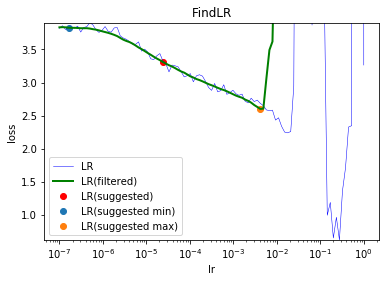

lr= 2.3988329190194914e-05, lr_min=1.6218100973589298e-07, lr_max=0.004168693834703356


In [83]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	3.14784257	3.49357215	0.29719042	15.872086
1	2.58724209	2.38807843	0.11361517	15.822706
2	2.00765561	1.62734698	0.14321239	15.887267
3	1.34144923	1.07759665	0.15244946	15.940663
4	0.78389236	0.59145313	0.10824521	15.991642
5	0.45041031	0.33690824	0.06611940	15.973810
6	0.27821071	0.23218474	0.11329117	16.066434
7	0.20113887	0.17806960	0.04001030	15.915405
8	0.16964924	0.16726200	0.12788019	16.121240
9	0.15857871	0.15020120	0.07143610	16.012679
10	0.14975464	0.14557095	0.04789439	16.105654
11	0.14508405	0.14249842	0.03484249	16.087385
12	0.14308668	0.14185993	0.05397622	15.988924
13	0.14172219	0.14071795	0.04299433	16.059108
14	0.13995799	0.13893182	0.03097897	16.091337
15	0.13930560	0.13822901	0.03178183	16.122049
16	0.13842898	0.13814313	0.03697233	16.049794
17	0.13824360	0.13714570	0.02991804	16.038940
18	0.13720111	0.13680122	0.02721470	16.058016
19	0.13713953	0.13695091	0.02764820	16.018336
i_epoch	loss(train)	loss(test)	metric(tes

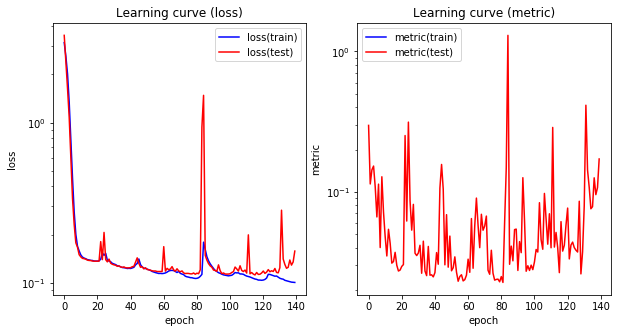

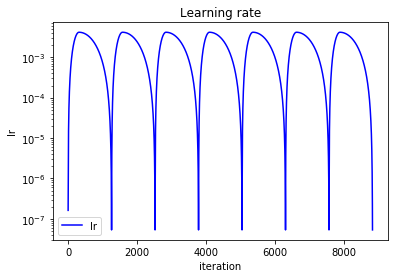

In [84]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-6,1e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
# lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(7):
  FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
print(f'best metric: {min(logger.metric_test)}')
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


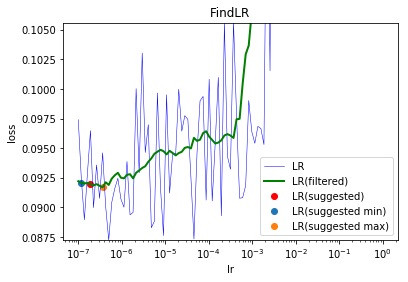

lr= 1.9054607179632472e-07, lr_min=1.1748975549395294e-07, lr_max=3.630780547701013e-07


In [85]:
f_loss.w_xtrg= 0.9
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))
UnfreezeAllParameters(net)

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
140	0.09400243	0.63482011	0.18336235	15.875889
141	0.09653325	0.19195089	0.06371555	15.967168
142	0.09854589	0.31039866	0.13456513	15.859711
143	0.09532914	0.15475307	0.05694932	15.994761
144	0.09405794	0.19332428	0.07183099	16.032892
145	0.09380218	0.15383030	0.05348699	15.964923
146	0.09314310	0.14837652	0.05144038	16.087406
147	0.09392122	0.23957746	0.09027331	16.017132
148	0.09315125	0.13918663	0.04635826	16.040803
149	0.09334743	0.17657951	0.06811042	16.033377
i_epoch	loss(train)	loss(test)	metric(test)	time
150	0.09333412	0.24018596	0.09839020	16.116317
151	0.09331545	0.26032319	0.09767628	16.052644
152	0.09338460	0.15510177	0.05730784	16.132836
153	0.09513256	0.18743380	0.07158696	16.081910
154	0.09319131	0.15007548	0.05511543	16.185915
155	0.09392354	0.17621577	0.06416815	16.067640
156	0.09226489	0.14383280	0.04909601	16.081228
157	0.09235900	0.14931336	0.05383821	16.123342
158	0.09223120	0.15950361	0.05607712	16.054999
159	0.091

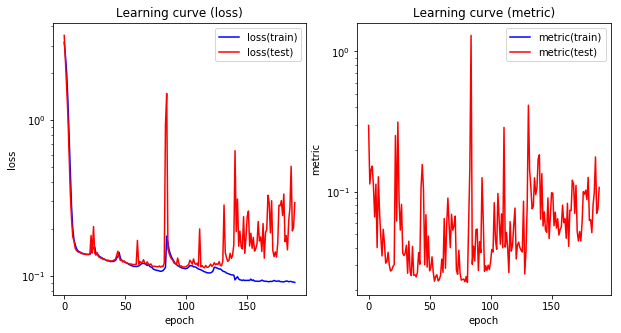

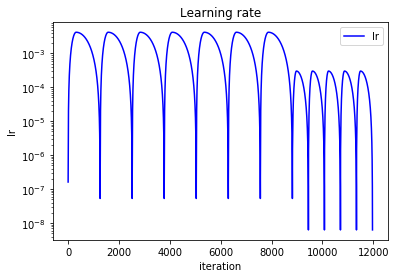

In [86]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,5e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
print(f'best metric: {min(logger.metric_test)}')
logger.Plot()
logger.PlotLR()

## Results with latent_dim=512
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=512, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

best loss(train): 0.09051736846329674
best loss(test): 0.11234068940393627
best metric(test): 0.022558557684533298


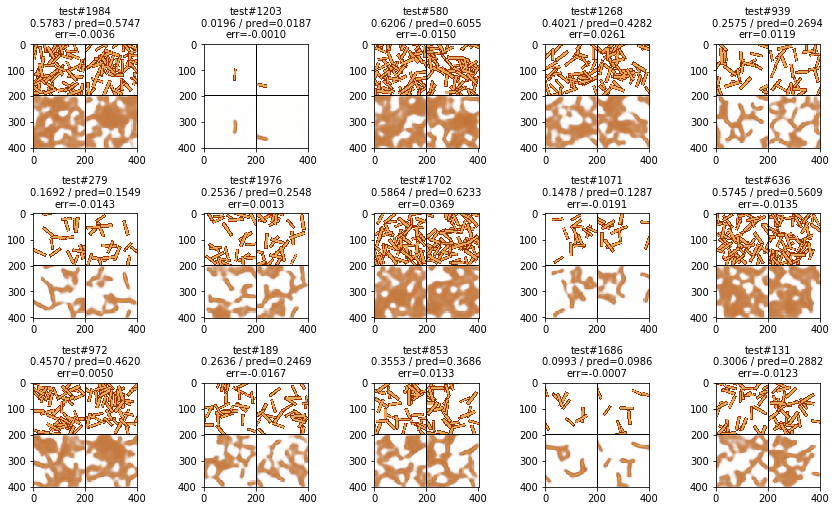

In [87]:
print(f'best loss(train): {min(logger.loss_train)}')
print(f'best loss(test): {min(logger.loss_test)}')
print(f'best metric(test): {min(logger.metric_test)}')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Results with latent_dim=256
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=256, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

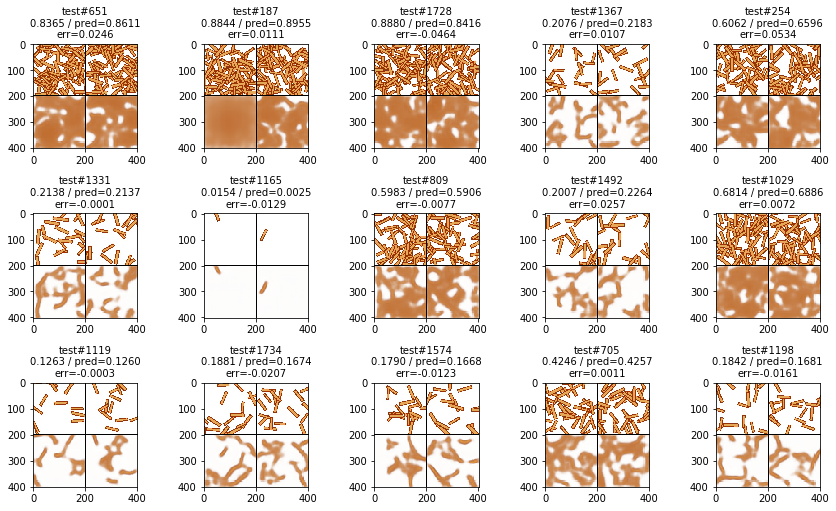

In [38]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Results with latent_dim=15
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=1, latent_dim=15, layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

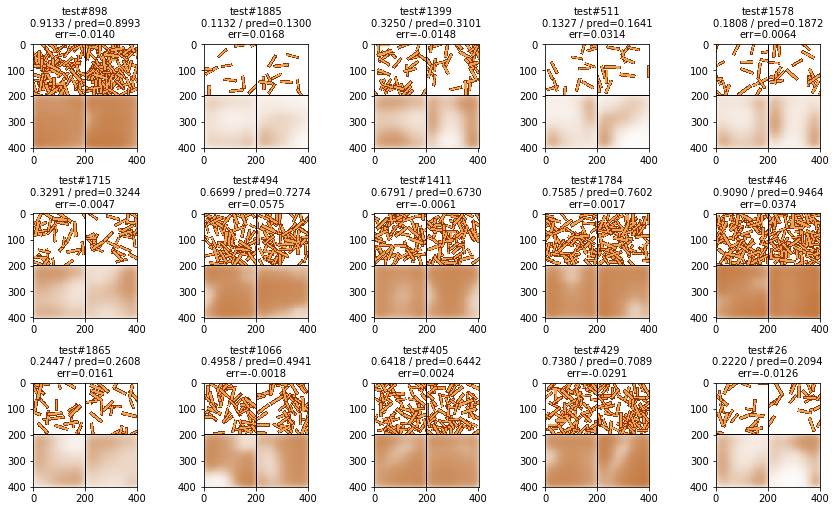

In [15]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

# ResNet with less stride and pooling

In [22]:
class TResDenseNetNSP(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, resnet_args=None,
               n_hiddens=2, hidden_channels=512, p_dropout=0.0):
    super(TResDenseNetNSP,self).__init__()
    self.expansion= 1
    self.kernel_size= 3
    self.ndim= 2
    self.respart= torch.nn.Sequential(
          ConvLayer(in_imgshape[0], 32, kernel_size=self.kernel_size, stride=1, ndim=self.ndim),
          # ConvLayer(32, 32, kernel_size=self.kernel_size, stride=1, ndim=self.ndim),
          TResBlock(self.expansion, 32, 64, stride=2, kernel_size=self.kernel_size),
          TResBlock(self.expansion, 64, 64, stride=1, kernel_size=self.kernel_size),
          ConvLayer(64, 1, kernel_size=1, stride=1, activation=None, ndim=self.ndim),
          getattr(torch.nn, f'AdaptiveAvgPool{self.ndim}d')(output_size=32),
          )
    ndim_respart= torch.flatten(self.respart(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    self.fc= torch.nn.Sequential(
          torch.nn.Flatten(),
          TResDenseBlock(ndim_respart*2, hidden_channels),
          torch.nn.Dropout(p_dropout),
          TResDenseBlock(hidden_channels, hidden_channels),
          torch.nn.Dropout(p_dropout),
          torch.nn.Linear(hidden_channels, out_channels),
          )
    InitCNN(self)
  def forward(self, x1, x2):
    x= torch.cat((self.respart(x1),self.respart(x2)),1)
    return self.fc(x)

In [23]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNetNSP(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),y
logger= TLogger()
disp= TDisp()

In [24]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, depth=7, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                        Output Shape              Param #
TResDenseNetNSP                               --                        --
├─Sequential: 1-1                             [1, 1, 32, 32]            --
│    └─Sequential: 2-1                        [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                       [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                         [1, 32, 200, 200]         --
│    └─TResBlock: 2-2                         [1, 64, 100, 100]         --
│    │    └─Sequential: 3-4                   [1, 64, 100, 100]         --
│    │    │    └─Sequential: 4-1              [1, 64, 100, 100]         --
│    │    │    │    └─Conv2d: 5-1             [1, 64, 100, 100]         18,432
│    │    │    │    └─BatchNorm2d: 5-2        [1, 64, 100, 100]         128
│    │    │    │    └─ReLU: 5-3               [1, 64, 100, 100]         --
│    │    │   

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


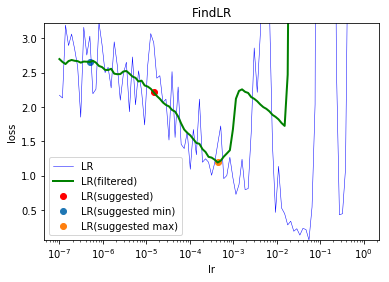

lr= 1.4791083881682072e-05, lr_min=5.011872336272723e-07, lr_max=0.0004365158322401661


In [25]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	1.85533383	0.91413650	0.94748263	18.449218
1	0.44283013	1.29519107	1.12853723	18.426554
2	0.39626720	0.34950109	0.58951454	18.482110
3	0.22129469	0.18768222	0.43158336	18.430509
4	0.09888201	0.12819128	0.35656267	18.527891
5	0.05147949	0.10129509	0.31667317	18.549345
6	0.03311066	0.09297307	0.30325401	18.579622
7	0.02586894	0.09322285	0.30342765	18.586874
8	0.02200476	0.09242321	0.30223895	18.587204
9	0.02125703	0.09035009	0.29878627	18.544177
i_epoch	loss(train)	loss(test)	metric(test)	time
10	0.02056663	0.09781854	0.31100459	18.657898
11	0.02755941	0.08678425	0.29283660	18.655978
12	0.03608812	0.10055542	0.31550847	18.658849
13	0.04487835	0.08725296	0.29417360	18.718811
14	0.03755807	0.05694353	0.23746114	18.703843
15	0.02498154	0.07179332	0.26687818	18.691374
16	0.01679424	0.04728017	0.21626727	18.695291
17	0.01408201	0.04493888	0.21102743	18.588923
18	0.01088179	0.04478806	0.21055977	18.647522
19	0.00923348	0.04270821	0.20550303	18

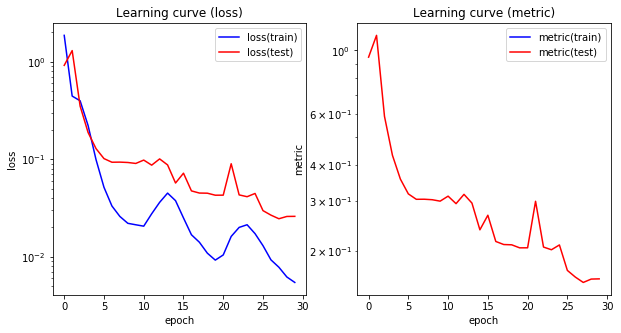

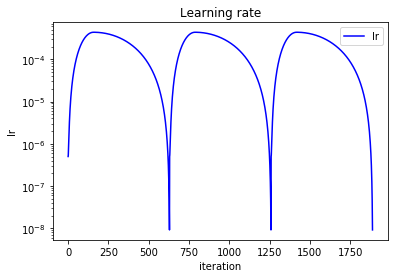

In [26]:
# lr_min/=2;lr_max/=2
# lr_min,lr_max= 1.e-7, 3.e-5
for i in range(3):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Plot()
logger.PlotLR()

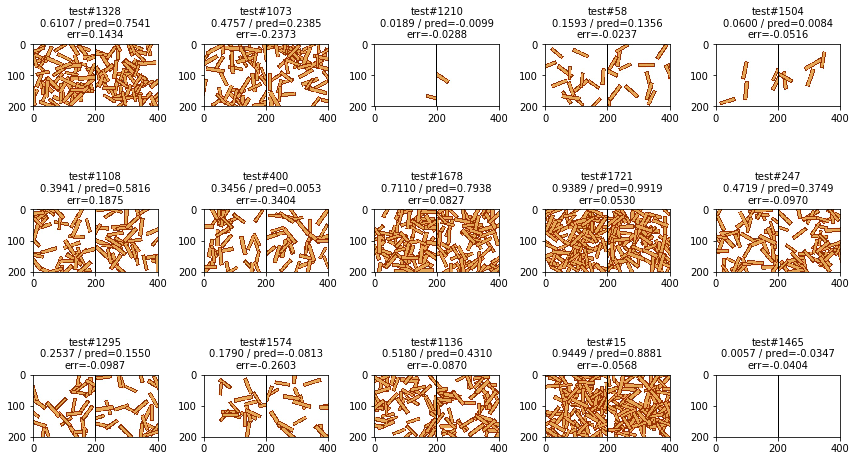

In [27]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= Eval(net,(imgs,imgsr),device=device).cpu()
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

# ResNet AE with less stride and pooling

In [40]:
class TResDenseNetWithAENSP(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels,
               latent_dim=512, hidden_channels=512, p_dropout=0.0):
    super(TResDenseNetWithAENSP,self).__init__()
    self.expansion= 1
    self.kernel_size= 3
    self.ndim= 2
    self.encoder= torch.nn.Sequential(
          ConvLayer(in_imgshape[0], 32, kernel_size=self.kernel_size, stride=1, ndim=self.ndim),
          # ConvLayer(32, 32, kernel_size=self.kernel_size, stride=1, ndim=self.ndim),
          TResBlock(self.expansion, 32, 64, stride=2, kernel_size=self.kernel_size),
          TResBlock(self.expansion, 64, 64, stride=1, kernel_size=self.kernel_size),
          ConvLayer(64, 1, kernel_size=1, stride=1, activation=None, ndim=self.ndim),
          getattr(torch.nn, f'AdaptiveAvgPool{self.ndim}d')(output_size=32),
          )
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    self.fc_latent= torch.nn.Sequential(
          torch.nn.Flatten(),
          # torch.nn.Linear(ndim_encoder, latent_dim),
          TResDenseBlock(ndim_encoder, latent_dim),
          )
    self.fc_out= torch.nn.Sequential(
          TResDenseBlock(latent_dim*2, hidden_channels),
          torch.nn.Dropout(p_dropout),
          # TResDenseBlock(hidden_channels, hidden_channels),
          # torch.nn.Dropout(p_dropout),
          torch.nn.Linear(hidden_channels, out_channels),
          )
    block_size0= latent_dim
    first_imgshape= (4,4)
    self.decoder= torch.nn.Sequential(
          torch.nn.Linear(latent_dim, block_size0*first_imgshape[0]*first_imgshape[1]), 
          torch.nn.Unflatten(1,(block_size0,first_imgshape[0],first_imgshape[1])),
          TResBlock(self.expansion, block_size0, 64, stride=2, kernel_size=self.kernel_size, transpose=True),
          TResBlock(self.expansion, 64, 64, stride=2, kernel_size=self.kernel_size, transpose=True),
          TResBlock(self.expansion, 64, 32, stride=2, kernel_size=self.kernel_size, transpose=True),
          ConvLayer(32, 32, kernel_size=self.kernel_size, stride=2, ndim=self.ndim, transpose=True),
          ConvLayer(32, in_imgshape[0], kernel_size=self.kernel_size, stride=2, ndim=self.ndim, transpose=True),
          torch.nn.Upsample(size=in_imgshape[1:]),
          )
    InitCNN(self)
  def forward(self, x1, x2):
    x1_encoded,x2_encoded= self.encoder(x1),self.encoder(x2)
    h1,h2= self.fc_latent(x1_encoded),self.fc_latent(x2_encoded)
    y= self.fc_out(torch.cat((h1,h2),1))
    x1_reconstructed,x2_reconstructed= self.decoder(h1),self.decoder(h2)
    return y, x1_reconstructed, x2_reconstructed, h1, h2

class TRDNAELoss2(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(TRDNAELoss2,self).__init__()
    self.w_xtrg= w_xtrg
  def state_dict(self):
    return {'w_xtrg':self.w_xtrg}
  def load_state_dict(self, d):
    self.w_xtrg= d['w_xtrg']
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    if self.w_xtrg==0:
      return torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
    elif self.w_xtrg==1:
      return torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
    else:
      x_loss= torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
      y_loss= torch.nn.functional.mse_loss(y, y_trg, reduction='sum')
      return self.w_xtrg*x_loss + (1.0-self.w_xtrg)*y_loss

class TRDNAEMetric2(torch.nn.Module):
  def __init__(self):
    super(TRDNAEMetric2,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    return torch.sqrt(torch.nn.functional.mse_loss(y, y_trg))

In [41]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNetWithAENSP(in_imgshape=in_imgshape, out_channels=1)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELoss2(w_xtrg=0.99)
f_metric= TRDNAEMetric2()

def decode(pred):
  y,x1_reconstructed,x2_reconstructed,h1,h2= pred
  return y

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),(y,x1,x2)
logger= TLogger()
disp= TDisp()

In [42]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, depth=7, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNetWithAENSP                              --                        --
├─Sequential: 1-1                                  [1, 1, 32, 32]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─TResBlock: 2-2                              [1, 64, 100, 100]         --
│    │    └─Sequential: 3-4                        [1, 64, 100, 100]         --
│    │    │    └─Sequential: 4-1                   [1, 64, 100, 100]         --
│    │    │    │    └─Conv2d: 5-1                  [1, 64, 100, 100]         18,432
│    │    │    │    └─BatchNorm2d: 5-2             [1, 64, 100, 100]         128
│    │    │    │    └─ReLU: 5

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


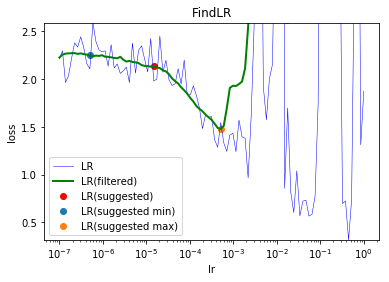

lr= 1.4791083881682072e-05, lr_min=5.011872336272723e-07, lr_max=0.000512861383991365


In [43]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
100	0.15334866	0.16070021	0.05656239	20.427770
101	0.15390677	0.16118267	0.05681013	20.483121
102	0.15500256	0.16715953	0.10959556	20.672641
103	0.15653227	0.16337615	0.06617876	20.641105
104	0.15700912	0.16875760	0.11616489	20.632532
105	0.15804597	0.16548827	0.09610817	20.793892
106	0.15728903	0.16403284	0.09312011	20.646091
107	0.15525066	0.16088150	0.06149878	20.733858
108	0.15515881	0.15983739	0.05772282	20.768428
109	0.15415151	0.15880293	0.05502252	20.749134
110	0.15276571	0.15757310	0.04773148	20.683734
111	0.15178622	0.15758117	0.05325168	20.734582
112	0.15138027	0.15794877	0.05985825	20.801795
113	0.15048535	0.16070628	0.09341193	20.693573
114	0.14981311	0.15655103	0.05175268	20.707378
115	0.14929416	0.15581387	0.04701246	20.773232
116	0.14877301	0.15567090	0.04739562	20.757281
117	0.14871965	0.15559779	0.04440694	20.742327
118	0.14851435	0.15621511	0.04749837	20.790710
119	0.14812881	0.15547675	0.04516517	20.826098
i_epoch	los

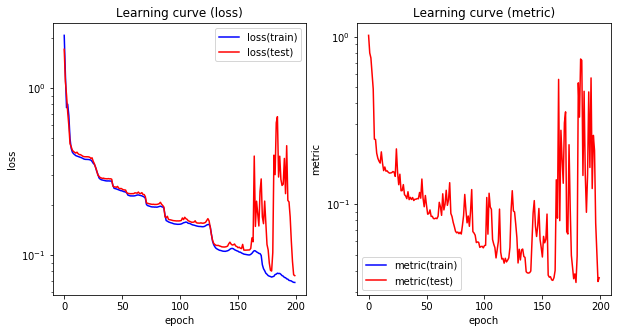

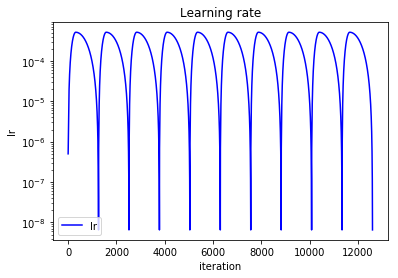

In [50]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
# lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(5):
  FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
print(f'best metric: {min(logger.metric_test)}')
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


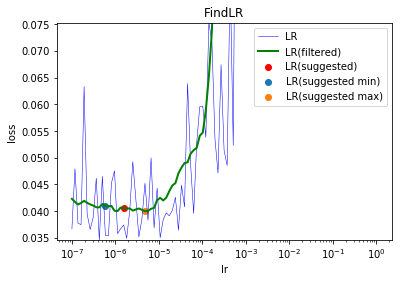

lr= 1.5488166189124815e-06, lr_min=5.888436553555889e-07, lr_max=4.7863009232263826e-06


In [55]:
f_loss.w_xtrg= 0.5
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))
# UnfreezeAllParameters(net)

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
300	0.03996842	0.07782693	0.03551999	20.586314
301	0.04092174	0.17278299	0.06472071	20.630228
302	0.04319230	0.91052351	0.16544872	20.651341
303	0.04248388	0.29452643	0.08907214	20.637333
304	0.04411962	0.27737797	0.08547502	20.662189
305	0.04442733	0.57152420	0.12849829	20.649869
306	0.04696126	0.47504188	0.11667634	20.606857
307	0.04280572	0.35831172	0.09993563	20.677139
308	0.04123035	1.26141970	0.19649548	20.708020
309	0.04158217	0.23050290	0.07752087	20.648328
310	0.04178665	0.15677091	0.06078437	20.703070
311	0.04089276	0.23452728	0.07870240	20.668708
312	0.04121864	0.09678999	0.04279035	20.755486
313	0.04113545	0.07717276	0.03491051	20.695491
314	0.04044439	0.09409447	0.04171374	20.740107
315	0.03964389	0.08605730	0.03867061	20.725606
316	0.03935061	0.07423784	0.03388031	20.790801
317	0.03837782	0.07599390	0.03480186	20.700771
318	0.03853836	0.08249661	0.03749020	20.736489
319	0.03899525	0.07716535	0.03523278	20.689953
i_epoch	los

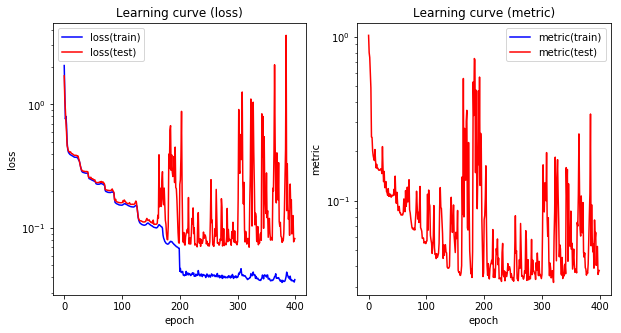

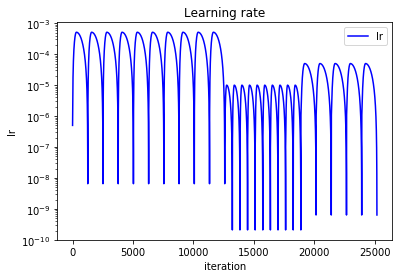

In [56]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
# lr_min,lr_max= 1e-6,3e-4
lr_min,lr_max= 1e-6,5e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
print(f'best metric: {min(logger.metric_test)}')
logger.Plot()
logger.PlotLR()

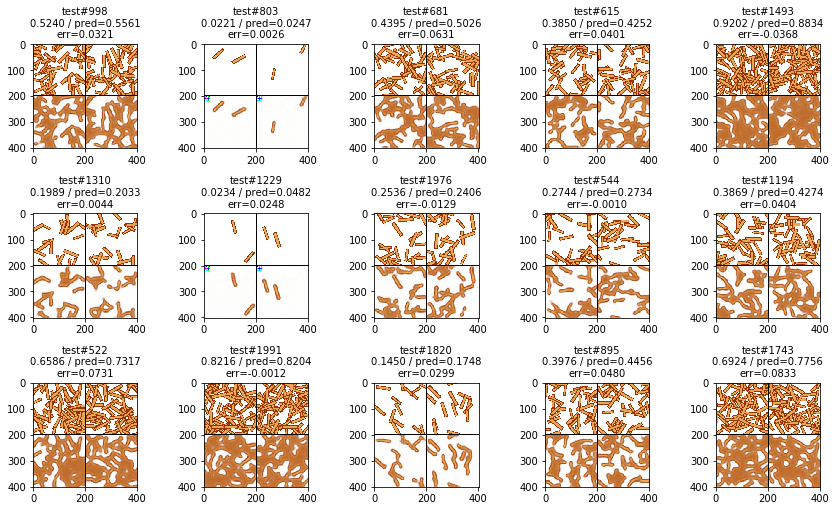

In [57]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= Eval(net,(imgs,imgsr),device=device)
pred_y,pred_x1,pred_x2= pred_y.cpu(),torch.clamp(pred_x1.cpu(),0,1),torch.clamp(pred_x2.cpu(),0,1)
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)